# Imports

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rc('figure', figsize=(21,7))

# Definitions

In [7]:
def diagref(**kwargs):
    plt.plot(*[plt.xlim()]*2, 'k--', zorder=-1)

def mae_info_planar(data=None, add_count=False, add_relative=False, **kwargs):
    text = f'MAE\n${1000*data.dE_defect_norm_model.mean():.2f}\,\mathrm{{meV/\AA}}^2$\n'
    if add_relative:
        text += f'${100*data.dE_defect_model_rel.mean():.2f}\,\%$'
    plt.text(.33, .7, text, transform=plt.gca().transAxes, ha='center')
    if add_count:
        plt.text(.66, .2, f'# {len(data)}', ha='center', transform=plt.gca().transAxes)

def mae_info_point(data=None, add_count=True, **kwargs):
    plt.text(.33, .7, 
         f'MAE\n${1000*data.dE_defect_model.mean():.2f}\,\mathrm{{meV}}$\n', 
         transform=plt.gca().transAxes, 
         ha='center')
    if add_count:
        plt.text(.66, .2, f'# {len(data)}', ha='center', transform=plt.gca().transAxes)

from scipy.spatial import ConvexHull

def get_convex(df, c, f, return_idx=False):
    dd = df.query(f'{f} <= 0')
    hull = ConvexHull(dd[[c, f]].to_numpy())
    points = hull.points[hull.vertices]
    points = points[np.argsort(points[:, 0])] # sort by concentration
    if not return_idx:
        return points.T
    else:
        return points.T, dd.index[hull.vertices]

def plot_binary_convex_hull(df, sharey=False, potential_name='MTP', model_name='DFT',
                            elements=['Al','Ca','Mg'],
                            label_structures=True):
    ylim = df[['E_formation', 'E_formation_model']].min(axis=None) * 1.2, df[['E_formation', 'E_formation_model']].max(axis=None) * 1.2
    for i, el in enumerate(elements):
        plt.subplot(1, len(elements), i+1)
        c = f'c_{elements[(i+1)%len(elements)]}'
        clabel = f'$c_\mathrm{{{elements[(i+1)%len(elements)]}}}$'
        ee = elements.copy()
        ee.remove(el)
        plt.title(''.join(sorted(ee)))
        dd = df.query(f'{el}==0')
        plt.plot(*get_convex(dd, c, 'E_formation'))
        plt.plot(*get_convex(dd, c, 'E_formation_model'))
        kwargs = {}
        if label_structures:
            kwargs['style'] = 'structure'
        t = sns.scatterplot(
            data=dd.rename({'E_formation': potential_name, 'E_formation_model': model_name}, axis='columns').melt(
                id_vars=[c,'structure'], 
                value_vars=[potential_name, model_name],
                var_name='model'
            ),
            x=c, y='value',
            hue='model', 
            s=200, alpha=.75,
            **kwargs
        )
        if sharey:
            plt.ylim(*ylim)
        plt.ylabel('$E_f$ [eV/atom]')
        plt.xlabel(clabel)
    plt.tight_layout()
    return t

# Plots

All the tables here have data for eight different potentials, the one discussed in the publication can be filter for by `level==24 and rmax==8.2`, see below.

## Bulk

In [11]:
bulk = pd.read_csv('Data/Bulk/Bulk.csv', index_col=0)

In [18]:
bulk = bulk.query('level==24 and rmax==8.2')

<Axes: title={'center': 'AlCa'}, xlabel='$c_\\mathrm{Al}$', ylabel='$E_f$ [eV/atom]'>

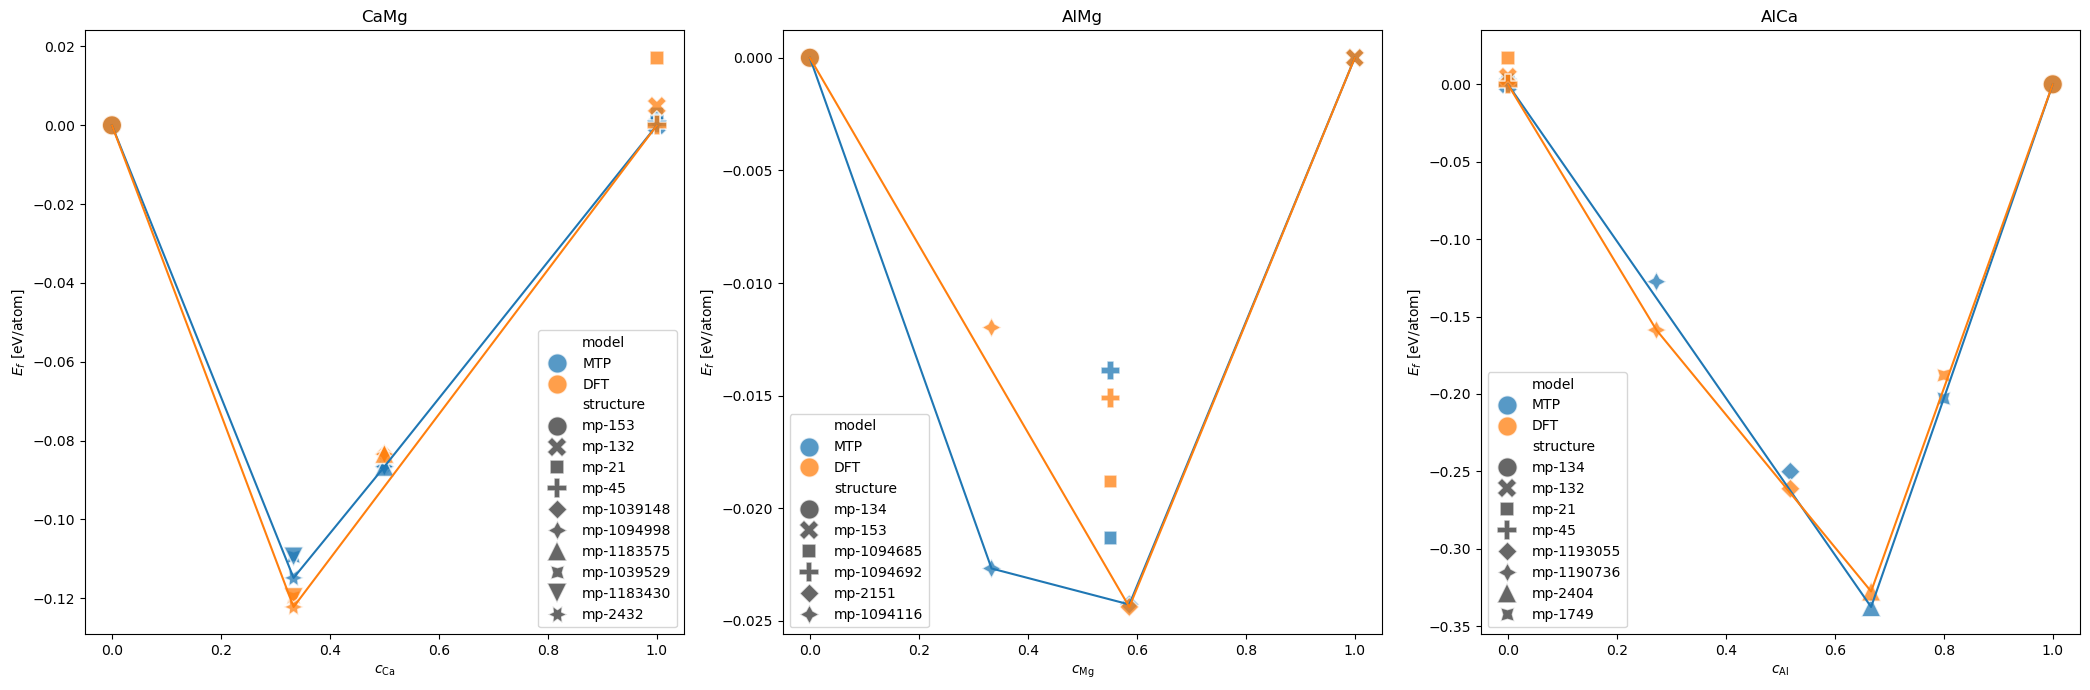

In [19]:
plot_binary_convex_hull(bulk)

## Volume

In [20]:
vol = pd.read_csv('Data/Volume/Volume.csv', index_col=0).query('level==24 and rmax==8.2')

In [26]:
vol.columns

Index(['Al', 'structure', 'E', 'V', 'N', 'Ca', 'Mg', 'chemical_formula',
       'set_strain', 'strain', 'E_strain', 'dE_ref', 'p', 'H', 'dH_ref',
       'E_formation', 'job', 'E_model', 'dE_ref_model', 'E_strain_model',
       'E_formation_model', 'strain_model', 'dE_model', 'ddE_ref',
       'dE_formation_model', 'dE_strain_model', 'name', 'level', 'rmax',
       'structure_file'],
      dtype='object')

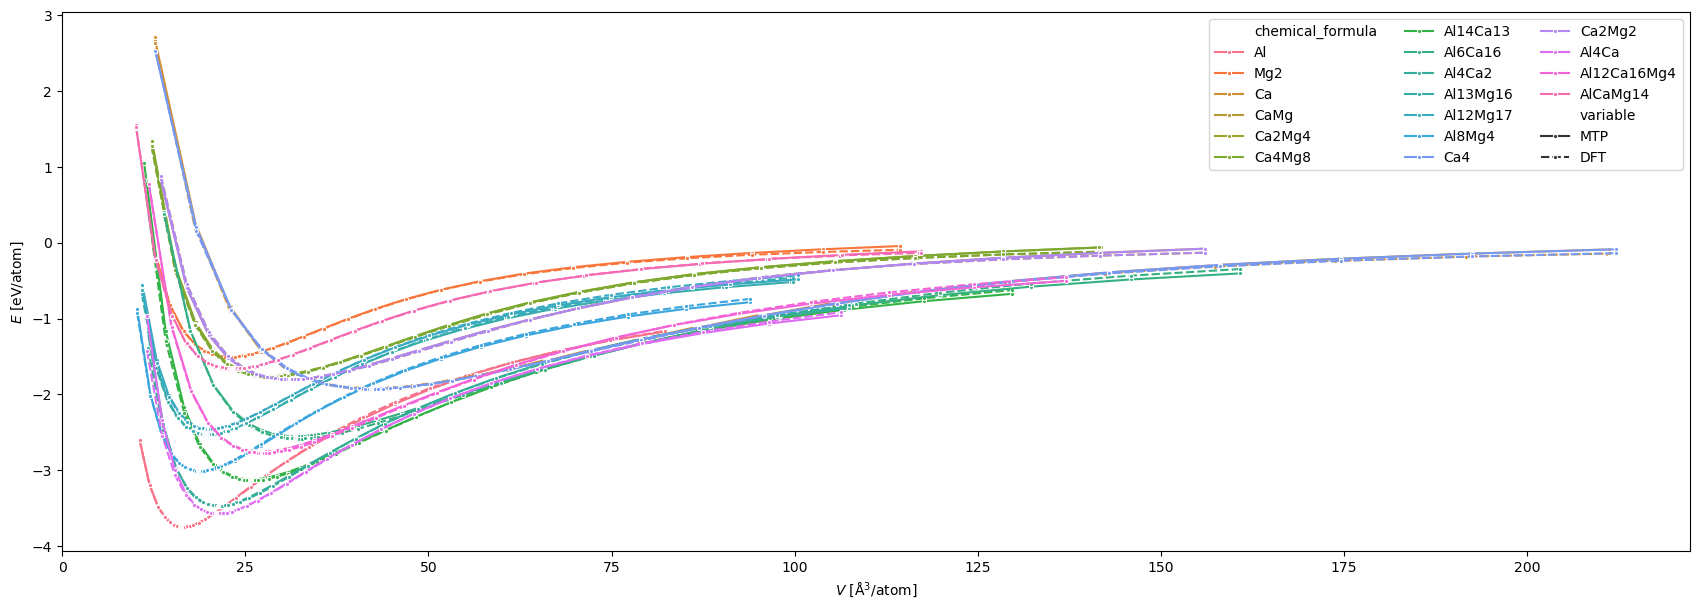

In [27]:
g = sns.lineplot(
    data=vol.melt(
        value_vars=['E', 'E_model'],
        id_vars=['V','chemical_formula','structure','level','rmax', 'name']
    ).replace({'E': 'MTP', 'E_model': 'DFT'}), 
    marker='.',
    x='V', y='value',
    hue='chemical_formula',
    style='variable',
    units='name', estimator=None,
).set(
    xlabel='$V$ [$\mathrm{\AA}^3$/atom]',
    ylabel='$E$ [eV/atom]',
)
plt.legend(ncols=3)

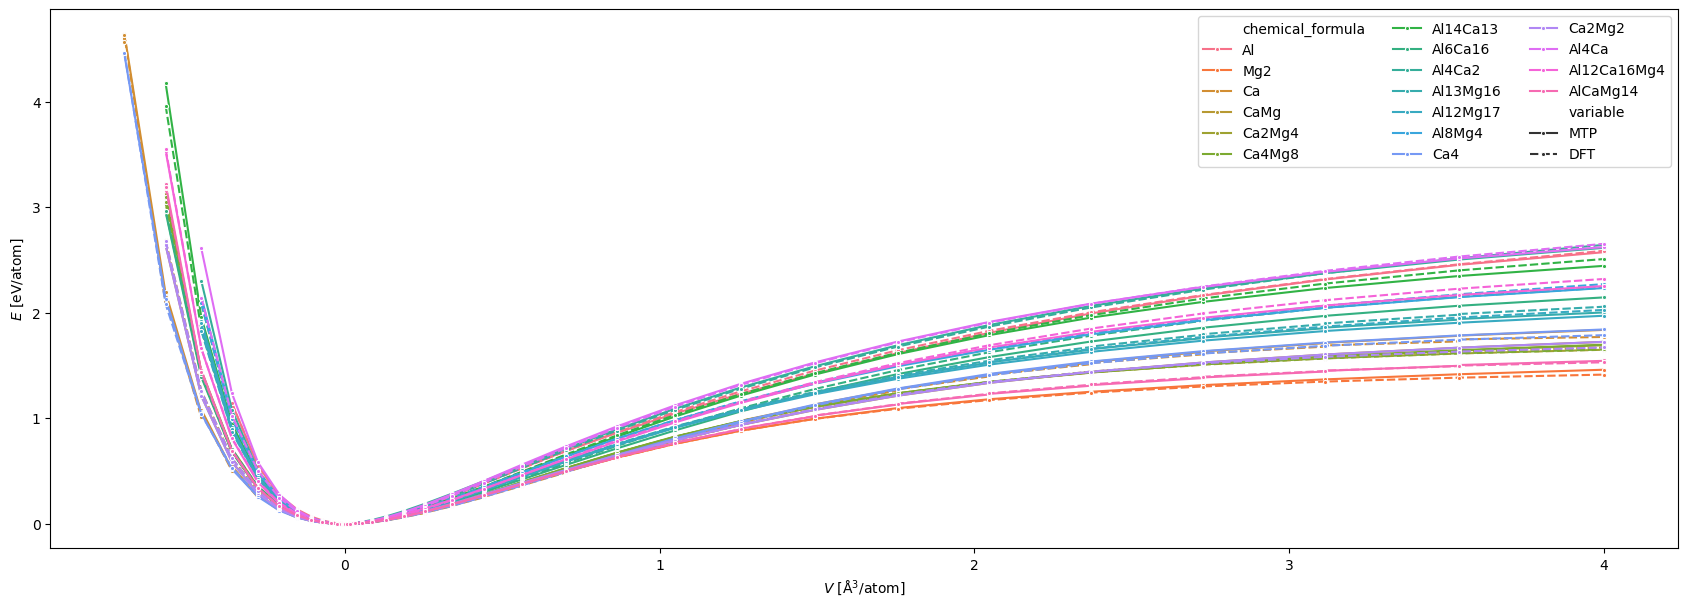

In [33]:
g = sns.lineplot(
    data=vol.melt(
        value_vars=['E_strain', 'E_strain_model'],
        id_vars=['strain', 'set_strain', 'V','chemical_formula','structure','level','rmax', 'name']
    ).replace({'E_strain': 'MTP', 'E_strain_model': 'DFT'}), 
    marker='.',
    x='set_strain', y='value',
    hue='chemical_formula',
    style='variable',
    units='name', estimator=None,
).set(
    xlabel='$V$ [$\mathrm{\AA}^3$/atom]',
    ylabel='$E$ [eV/atom]',
)
plt.legend(ncols=3)

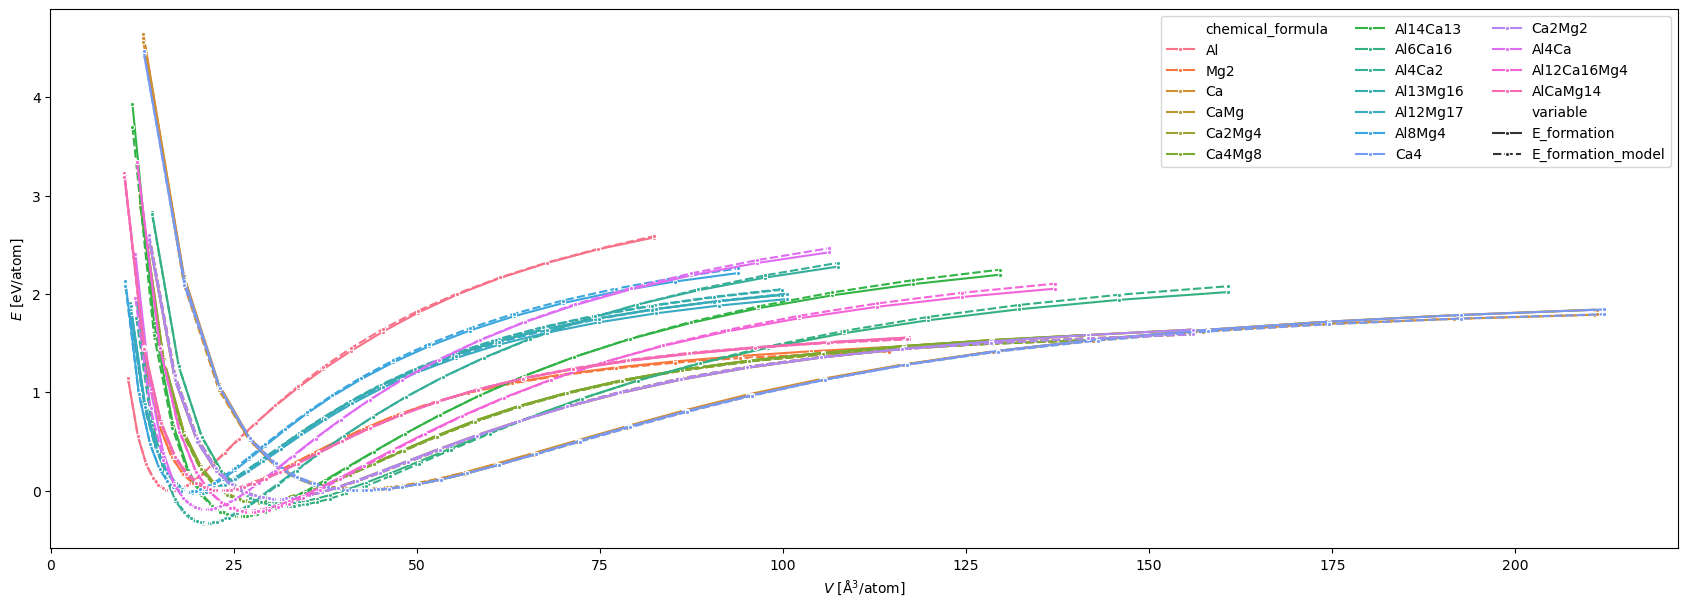

In [37]:
g = sns.lineplot(
    data=vol.melt(
        value_vars=['E_formation', 'E_formation_model'],
        id_vars=['V','chemical_formula','structure','level','rmax', 'name']
    ).replace({'E': 'MTP', 'E_model': 'DFT'}), 
    marker='.',
    x='V', y='value',
    hue='chemical_formula',
    style='variable',
    units='structure', estimator=None,
).set(
    xlabel='$V$ [$\mathrm{\AA}^3$/atom]',
    ylabel='$E$ [eV/atom]',
)
plt.legend(ncols=3)

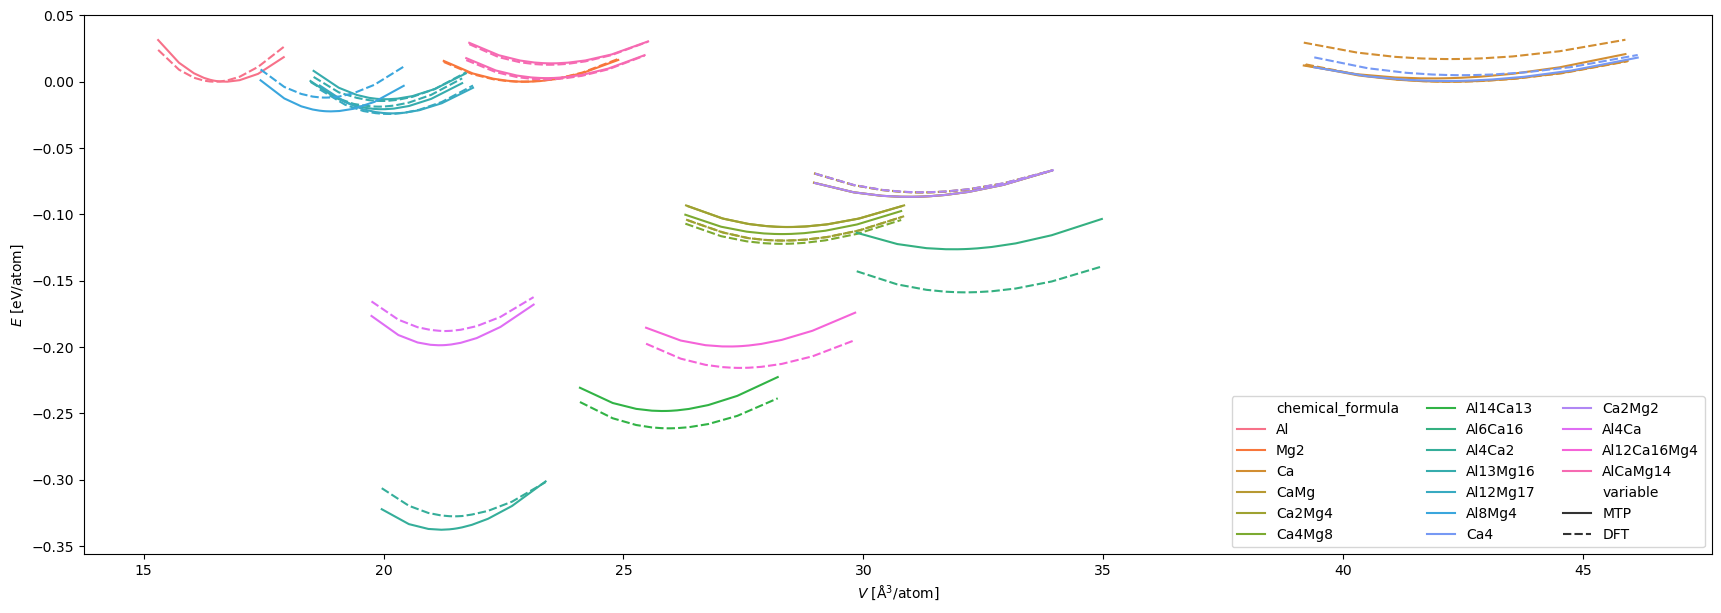

In [36]:
g = sns.lineplot(
    data=vol.query('abs(set_strain)<.1').melt(
        value_vars=['E_formation', 'E_formation_model'],
        id_vars=['V','chemical_formula','structure','level','rmax', 'name']
    ).replace({'E_formation': 'MTP', 'E_formation_model': 'DFT'}), 
    x='V', y='value',
    hue='chemical_formula',
    style='variable',
    units='structure', estimator=None,
).set(
    xlabel='$V$ [$\mathrm{\AA}^3$/atom]',
    ylabel='$E$ [eV/atom]',
)
plt.legend(ncols=3)

## Phase Diagrams

In [38]:
mgal = pd.read_csv("Data/PhaseDiagrams/MgAl/phasediagram.csv", index_col=0)

<Axes: xlabel='c', ylabel='T'>

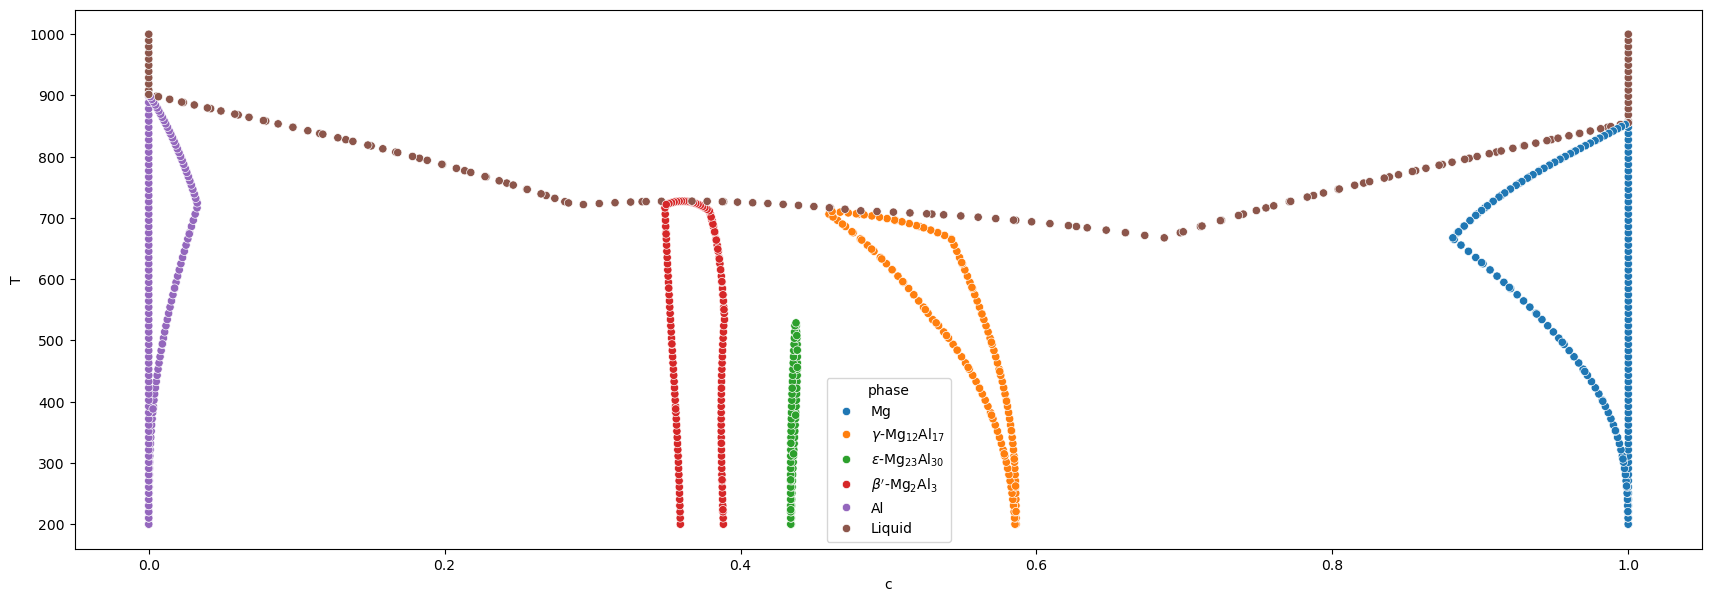

In [44]:
sns.scatterplot(
    data=mgal.query('border'),
    x='c', y='T',
    hue='phase'
)